<a href="https://colab.research.google.com/github/shubhipandeyofficial/form/blob/main/brain_tumor_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 76% 66.0M/86.8M [00:00<00:00, 185MB/s]
100% 86.8M/86.8M [00:00<00:00, 180MB/s]


In [3]:
import zipfile
zip_ref=zipfile.ZipFile('/content/brain-tumor-classification-mri.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.math import  confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Upload vgg16 pretrained model to use it in the transfer learning
from tensorflow.keras.applications import VGG16
import random
random.seed(10)
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_directory = '/content/Training'
test_directory = '/content/Testing'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']  # Update with actual category names
image_size = 150

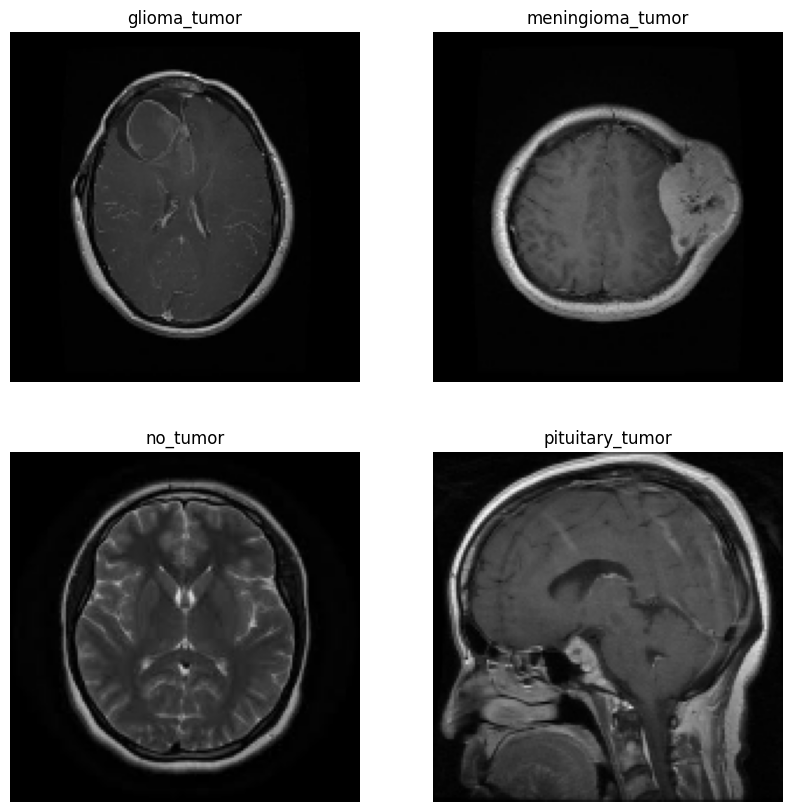

In [6]:
train_data = []
plt.figure(figsize=(10, 10))
for label in range(len(categories)):
    class_name = categories[label]
    class_path = os.path.join(train_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image_resized = cv2.resize(image, (image_size, image_size))
            train_data.append([image_resized, label])
    plt.subplot(2, 2, label + 1)
    plt.axis('off')
    plt.title(class_name)
    plt.imshow(image_resized)
plt.show()

# Load test dataset
test_data = []
for label in range(len(categories)):
    class_name = categories[label]
    class_path = os.path.join(test_directory, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image_resized = cv2.resize(image, (image_size, image_size))
            test_data.append([image_resized, label])

In [7]:
# Shuffle training data
random.shuffle(train_data)

In [8]:
# Split training data into features and labels
X_train = np.array([i[0] for i in train_data])
Y_train = np.array([i[1] for i in train_data])

# Split test data into features and labels
X_test = np.array([i[0] for i in test_data])
Y_test = np.array([i[1] for i in test_data])

In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# One-hot encode the labels
Y_train_cat = to_categorical(Y_train, num_classes=len(categories))
Y_test_cat = to_categorical(Y_test, num_classes=len(categories))

Unique values of labels are: [0 1 2 3]


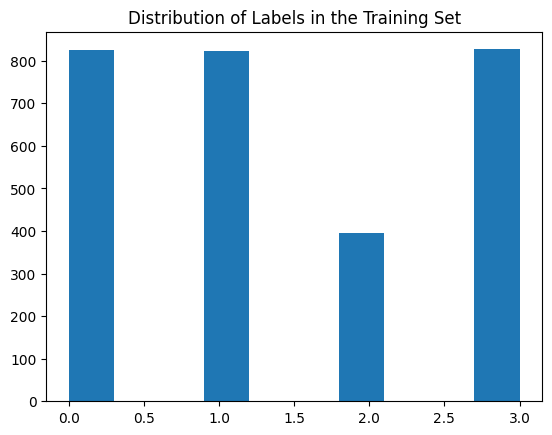

In [11]:
# Check unique values in the training label data
unique_labels = np.unique(Y_train)
print(f"Unique values of labels are: {unique_labels}")

# Distribution of labels
plt.hist(Y_train)
plt.title("Distribution of Labels in the Training Set")
plt.show()

In [12]:
# Checking for any missing values
print("Training data has missing values:", np.isnan(X_train).any())
print("Testing data has missing values:", np.isnan(X_test).any())

Training data has missing values: False
Testing data has missing values: False


In [13]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [15]:
# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train model
history = model.fit(X_train, Y_train_cat, epochs=20, validation_data=(X_test, Y_test_cat))

Epoch 1/20
90/90 [==============================] - 11s 41ms/step - loss: 1.0147 - accuracy: 0.5662 - val_loss: 1.5156 - val_accuracy: 0.4518
Epoch 2/20
90/90 [==============================] - 2s 25ms/step - loss: 0.6854 - accuracy: 0.7125 - val_loss: 1.8254 - val_accuracy: 0.5025
Epoch 3/20
90/90 [==============================] - 2s 25ms/step - loss: 0.5124 - accuracy: 0.7895 - val_loss: 1.7145 - val_accuracy: 0.5431
Epoch 4/20
90/90 [==============================] - 2s 28ms/step - loss: 0.3772 - accuracy: 0.8474 - val_loss: 2.1192 - val_accuracy: 0.6320
Epoch 5/20
90/90 [==============================] - 2s 26ms/step - loss: 0.2914 - accuracy: 0.8875 - val_loss: 2.1488 - val_accuracy: 0.6497
Epoch 6/20
90/90 [==============================] - 2s 25ms/step - loss: 0.2019 - accuracy: 0.9195 - val_loss: 2.9250 - val_accuracy: 0.7005
Epoch 7/20
90/90 [==============================] - 2s 25ms/step - loss: 0.1662 - accuracy: 0.9408 - val_loss: 2.3000 - val_accuracy: 0.7107
Epoch 8/20
9

In [17]:
loss_train, accuracy_train = model.evaluate(X_train, Y_train_cat)
loss_test, accuracy_test = model.evaluate(X_test, Y_test_cat)
print(f'Training Accuracy: {accuracy_train}, Training Loss: {loss_train}')
print(f'Testing Accuracy: {accuracy_test}, Testing Loss: {loss_test}')

13/13 [==============================] - 0s 10ms/step - loss: 5.8098 - accuracy: 0.7030
Training Accuracy: 0.998954713344574, Training Loss: 0.005775514058768749
Testing Accuracy: 0.703045666217804, Testing Loss: 5.809759140014648


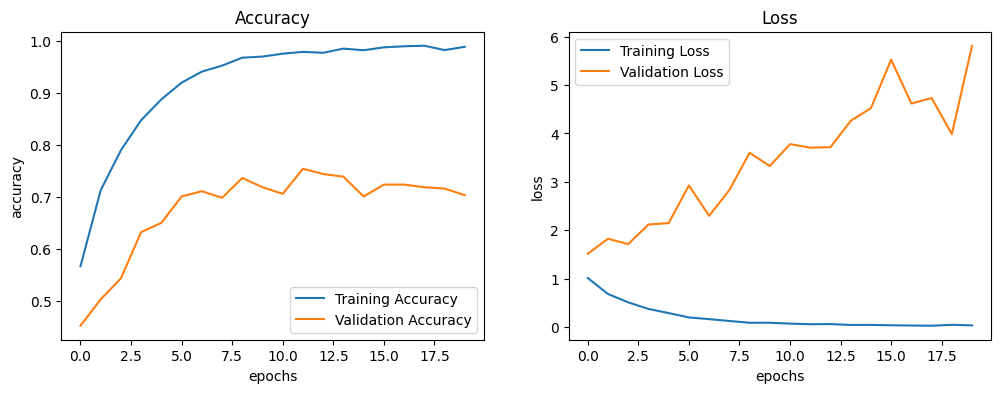

In [18]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.title('Loss')

plt.show()

In [19]:
# Make predition on the test data
predictions = model.predict(X_test)

13/13 [==============================] - 0s 13ms/step


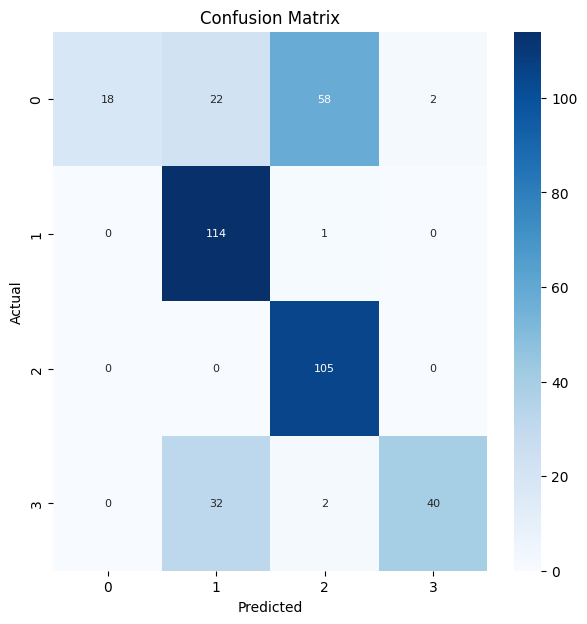

In [20]:
# Create confusion matrix
cm = confusion_matrix(Y_test, np.argmax(predictions, axis=1))
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, fmt='1.0f', cmap='Blues', cbar = True, annot_kws={"size": 8})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Create classification report
cr = classification_report(Y_test, np.argmax(predictions, axis=1))
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.18      0.31       100
           1       0.68      0.99      0.81       115
           2       0.63      1.00      0.77       105
           3       0.95      0.54      0.69        74

    accuracy                           0.70       394
   macro avg       0.82      0.68      0.64       394
weighted avg       0.80      0.70      0.65       394



In [22]:
# Load the VGG16 model pre-trained on ImageNet, exclude top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [23]:
# Unfreeze the top layers of VGG16
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:  # Unfreeze the last 4 layers for example
    layer.trainable = False

In [24]:
# Build the model
model_tl = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [25]:
# Print model summary
model_tl.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                

In [26]:
# Compile the model
model_tl.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [28]:
# Train the model with data augmentation and callbacks
history_tl = model_tl.fit(
    X_train, Y_train_cat,
    epochs=100,
    validation_data=(X_test, Y_test_cat),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
90/90 [==============================] - 21s 159ms/step - loss: 7.8313 - accuracy: 0.3934 - val_loss: 7.7019 - val_accuracy: 0.3046 - lr: 1.0000e-05
Epoch 2/100
90/90 [==============================] - 9s 105ms/step - loss: 7.1701 - accuracy: 0.5955 - val_loss: 7.4304 - val_accuracy: 0.3832 - lr: 1.0000e-05
Epoch 3/100
90/90 [==============================] - 9s 104ms/step - loss: 6.7491 - accuracy: 0.6780 - val_loss: 7.1751 - val_accuracy: 0.4442 - lr: 1.0000e-05
Epoch 4/100
90/90 [==============================] - 9s 103ms/step - loss: 6.3767 - accuracy: 0.7523 - val_loss: 6.9602 - val_accuracy: 0.4949 - lr: 1.0000e-05
Epoch 5/100
90/90 [==============================] - 9s 101ms/step - loss: 6.1365 - accuracy: 0.7735 - val_loss: 6.7464 - val_accuracy: 0.5381 - lr: 1.0000e-05
Epoch 6/100
90/90 [==============================] - 9s 100ms/step - loss: 5.8878 - accuracy: 0.7962 - val_loss: 6.5241 - val_accuracy: 0.5812 - lr: 1.0000e-05
Epoch 7/100
90/90 [====================

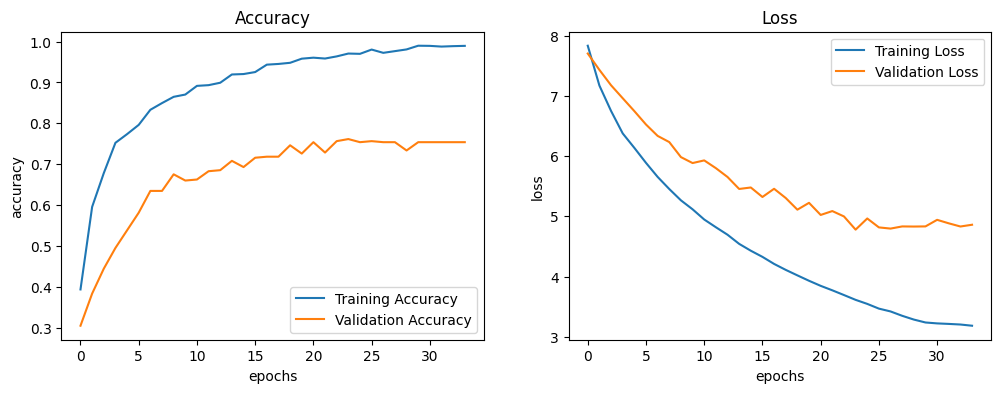

In [29]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Training Accuracy')
plt.plot(history_tl.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Training Loss')
plt.plot(history_tl.history['val_loss'], label='Validation Loss')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.legend()
plt.title('Loss')

plt.show()

In [30]:
loss_train_tl, accuracy_train_tl = model_tl.evaluate(X_train, Y_train_cat)
loss_test_tl, accuracy_test_tl = model_tl.evaluate(X_test, Y_test_cat)
print(f'Training Accuracy: {accuracy_train_tl}, Training Loss: {loss_train_tl}')
print(f'Testing Accuracy: {accuracy_test_tl}, Testing Loss: {loss_test_tl}')

13/13 [==============================] - 1s 68ms/step - loss: 4.7801 - accuracy: 0.7614
Training Accuracy: 0.9923344850540161, Training Loss: 3.5229103565216064
Testing Accuracy: 0.7614213228225708, Testing Loss: 4.780113697052002


In [31]:
# Make predition on the test data
predictions_tl = model_tl.predict(X_test)

13/13 [==============================] - 1s 71ms/step


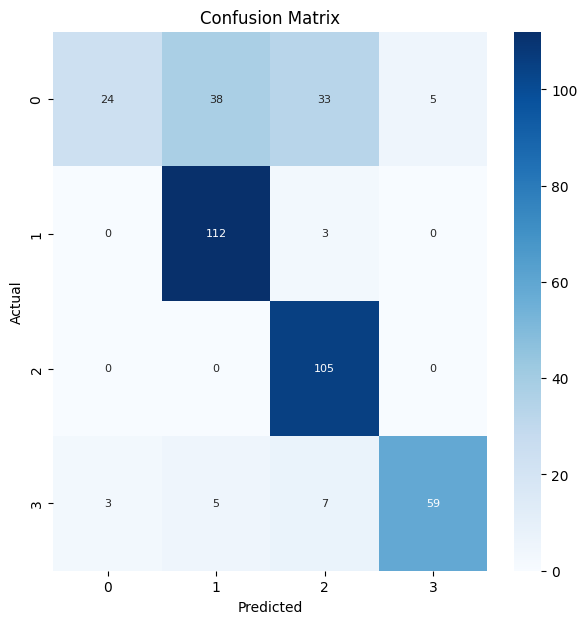

In [32]:
# Create confusion matrix
cm_tl = confusion_matrix(Y_test, np.argmax(predictions_tl, axis=1))
plt.figure(figsize = (7,7))
sns.heatmap(cm_tl, annot=True, fmt='1.0f', cmap='Blues', cbar = True, annot_kws={"size": 8})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
# Create classification report
cr_tl = classification_report(Y_test, np.argmax(predictions_tl, axis=1))
print(cr_tl)

              precision    recall  f1-score   support

           0       0.89      0.24      0.38       100
           1       0.72      0.97      0.83       115
           2       0.71      1.00      0.83       105
           3       0.92      0.80      0.86        74

    accuracy                           0.76       394
   macro avg       0.81      0.75      0.72       394
weighted avg       0.80      0.76      0.72       394

